In [1]:
%matplotlib inline
import numpy as np
import nibabel as nib
import pandas as pd
import os, glob, re
from os.path import join
from pathlib import Path
import nilearn
from nilearn import image, plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from scipy.stats import norm
from nilearn import plotting
from nilearn.glm.second_level import SecondLevelModel
from neuromaps.transforms import mni152_to_fslr, mni152_to_fsaverage, mni152_to_civet
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
from neuromaps.datasets import fetch_atlas, fetch_fslr, fetch_fsaverage
from surfplot import Plot
from surfplot.utils import threshold

from neuromaps.datasets import fetch_fslr



# resources
* https://www.cs.utexas.edu/users/evouga/uploads/4/5/6/8/45689883/notes3.pdf
* https://www.cs.cmu.edu/~kmcrane/Projects/Other/TriangleMeshDerivativesCheatSheet.pdf

In [185]:
def surf_data_save(mni_img_obj, output_dir, output_fname):
    """
    convert an mni object into fsLR and save as .surf.gii

    Args:
        mni_img_obj (nibabel.nifti1.Nifti1Image): statistical map
        output_dir (str): directory to save surf.gii
        output_fname (str): filename to save
    """
    from neuromaps.transforms import mni152_to_fslr
    from neuromaps.datasets import fetch_atlas
    fslrlh, fslrrh = mni152_to_fslr(mni_img_obj)
    fslr = fetch_atlas('fsLR', '32k')
    fslr_left_infl = nib.load(fslr['inflated'].L)
    fslr_left_infl.add_gifti_data_array(fslrlh.darrays[0])
    nib.save(fslr_left_infl, join(output_dir, f'{output_fname}L.surf.gii'))


    fslr_right_infl = nib.load(fslr['inflated'].R)
    fslr_right_infl.add_gifti_data_array(fslrrh.darrays[0])
    nib.save(fslr_right_infl, join(output_dir, f'{output_fname}R.surf.gii'))

def load_and_rm_medial(surf_gii_fname, surf_gii_folder, hemi):
    """
    Load a surf.gii file and remove the medial wall vertices.

        Args:
            surf_gii_fname (str): The filename of the surf.gii file to load.
            surf_gii_folder (str): The directory where the surf.gii file is located.
            hemi (str): The hemisphere, either 'L' for left or 'R' for right.

        Returns:
            vertices (numpy.ndarray): An array of vertex coordinates with medial wall vertices set to NaN.
            triangles (numpy.ndarray): An array representing the triangles of the surface.
            data (numpy.ndarray): An array of associated data with medial wall values set to NaN.

    """
    from neuromaps.datasets import fetch_atlas, fetch_fslr
    fslr = fetch_atlas('fsLR', '32k')
    TESTl = nib.load(join(surf_gii_folder, f'{surf_gii_fname}{hemi}.surf.gii'))
    print(f"input surface data: {join(surf_gii_folder, f'{surf_gii_fname}{hemi}.surf.gii')}")
    if hemi == 'L':
        fslr_medial_infl = nib.load(fslr['medial'].L)
    elif hemi == 'R':
        fslr_medial_infl = nib.load(fslr['medial'].R)
    medial_index = np.where(fslr_medial_infl.darrays[0].data ==0)[0]

    vertices_load = TESTl.darrays[0].data
    triangles_load = TESTl.darrays[1].data
    data_load = TESTl.darrays[2].data

    vertices = np.copy(vertices_load)
    vertices[medial_index] = np.nan
    data = np.copy(data_load)
    data[medial_index] = np.nan
    triangles = triangles_load
    return vertices, triangles, data

def calc_normal_vector(vertices, triangles):
    """
    Calculate the normal vectors for vertices in a 3D surface mesh.
    This will be the average orientation of neighboring triangles at each vertex.

    Args:
        vertices (numpy.ndarray): An array of vertex coordinates.
        triangles (numpy.ndarray): An array representing the triangles of the surface.

    Returns:
        vertex_normals (numpy.ndarray): An array of normal vectors for each vertex.
    """
    vertex_normals = np.zeros_like(vertices)
    for triangle in triangles:
        v1 = vertices[triangle[0]]
        v2 = vertices[triangle[1]]
        v3 = vertices[triangle[2]]
        triangle_normal = np.cross(v2 - v1, v3 - v1)
        # Add the triangle normal to the vertex normals of its vertices
        vertex_normals[triangle] += triangle_normal
    # Normalize the vertex normals
    vertex_normals /= np.linalg.norm(vertex_normals, axis=1)[:, np.newaxis]
    return vertex_normals

def calc_gradient(vertex_normals, triangles, vertices, data):
    """
    Calculate the gradient field on a 3D surface mesh based on vertex normals and associated data.

    Args:
        vertex_normals (numpy.ndarray): An array of normal vectors for each vertex.
        triangles (numpy.ndarray): An array representing the triangles of the surface.
        vertices (numpy.ndarray): An array of vertex coordinates.
        data (numpy.ndarray): An array of univariate activation values (Z or beta) associated with each vertex.

    Returns:
        gradient_field (numpy.ndarray): An array containing gradient values at each vertex.
    """
    gradient_field = np.zeros(vertices.shape[0])
    # Calculate the gradient field at each vertex based on the associated data
    for vertex_idx, vertex in enumerate(vertices):
        # Calculate the gradient as the weighted sum of neighboring vertex normals, weighted by the associated data
        neighbors = np.where(triangles == vertex_idx)[0]
        # print(neighbors)
        gradient = vertex_normals[triangles[neighbors]] * data[triangles[neighbors]][:, np.newaxis]
        # print(gradient.shape)
        gradient_sum = np.sum(gradient)
        
        # Store the gradient in the gradient field
        gradient_field[vertex_idx] = np.linalg.norm(gradient_sum)
    return gradient_field #, len(weighted_normals), vertex_normals, triangles, neighbors


import numpy as np

def calc_gradient_vector(vertex_normals, triangles, vertices, data):
    """
    Calculate the gradient field on a 3D surface mesh based on vertex normals and associated data.

    Args:
        vertex_normals (numpy.ndarray): An array of normal vectors for each vertex.
        triangles (numpy.ndarray): An array representing the triangles of the surface.
        vertices (numpy.ndarray): An array of vertex coordinates.
        data (numpy.ndarray): An array of univariate activation values (Z or beta) associated with each vertex.

    Returns:
        gradient_x (numpy.ndarray): An array containing the X-component of the gradient at each vertex.
        gradient_y (numpy.ndarray): An array containing the Y-component of the gradient at each vertex.
        gradient_z (numpy.ndarray): An array containing the Z-component of the gradient at each vertex.
    """
    gradient_x = np.zeros((vertices.shape[0], 3))
    gradient_y = np.zeros((vertices.shape[0], 3))
    gradient_z = np.zeros((vertices.shape[0], 3))
    for vertex_idx, vertex in enumerate(vertices):
        # Calculate the gradient as the weighted sum of neighboring vertex normals, weighted by the associated data
        neighbors = np.where(triangles == vertex_idx)[0]
        # weighted_normals = vertex_normals[triangles[neighbors]]

        # Initialize gradient components
        gradient_x_sum = 0.0
        gradient_y_sum = 0.0
        gradient_z_sum = 0.0

        for i in range(len(neighbors)):
            weighted_normal = vertex_normals[triangles[neighbors]][i]
            weight = data[triangles[neighbors[i]]]

            gradient_x_sum += weighted_normal[0] * weight
            gradient_y_sum += weighted_normal[1] * weight
            gradient_z_sum += weighted_normal[2] * weight

        gradient_x[vertex_idx] = gradient_x_sum #.reshape(1,3).shape
        gradient_y[vertex_idx] = gradient_y_sum #.reshape(1,3).shape
        gradient_z[vertex_idx] = gradient_z_sum #.reshape(1,3).shape
    return gradient_x, gradient_y, gradient_z

def calc_gradient_vectorv2(vertex_normals, triangles, vertices, data):
    """
    Calculate the gradient field on a 3D surface mesh based on vertex normals and associated data.

    Args:
        vertex_normals (numpy.ndarray): An array of normal vectors for each vertex.
        triangles (numpy.ndarray): An array representing the triangles of the surface.
        vertices (numpy.ndarray): An array of vertex coordinates.
        data (numpy.ndarray): An array of univariate activation values (Z or beta) associated with each vertex.

    Returns:
        gradient_x (numpy.ndarray): An array containing the X-component of the gradient at each vertex.
        gradient_y (numpy.ndarray): An array containing the Y-component of the gradient at each vertex.
        gradient_z (numpy.ndarray): An array containing the Z-component of the gradient at each vertex.
    """
    gradient_x = np.zeros((vertices.shape[0], 3))
    gradient_y = np.zeros((vertices.shape[0], 3))
    gradient_z = np.zeros((vertices.shape[0], 3))

    gradients = np.zeros((vertices.shape,  3, 3))

    for vertex_idx, vertex in enumerate(vertices):
        # Calculate the gradient as the weighted sum of neighboring vertex normals, weighted by the associated data
        neighbors = np.where(triangles == vertex_idx)[0]
        weighted_normals = vertex_normals[triangles[neighbors]]

        # Initialize gradient components
        gradient_x_sum = 0.0
        gradient_y_sum = 0.0
        gradient_z_sum = 0.0

        for i in range(len(neighbors)):
            weighted_normal = weighted_normals[i]
            weight = data[triangles[neighbors[i]]]

            gradient_x_sum += vertex_normals[triangles[neighbors]][0] * data[triangles[neighbors[i]]]
            gradient_y_sum += vertex_normals[triangles[neighbors]][1] * data[triangles[neighbors[i]]]
            gradient_z_sum += vertex_normals[triangles[neighbors]][2] * data[triangles[neighbors[i]]]

        gradient_x[vertex_idx] = gradient_x_sum #.reshape(1,3).shape
        gradient_y[vertex_idx] = gradient_y_sum #.reshape(1,3).shape
        gradient_z[vertex_idx] = gradient_z_sum #.reshape(1,3).shape
    return gradient_x, gradient_y, gradient_z

def gii_calc_gradient(surf_gii_fname, surf_gii_folder, hemi):
    """Series of functions for ultimately calculating gradient

    Args:
        surf_gii_fname (str): [description]
        surf_gii_folder (str): [description]
        hemi (str): [description]

    Returns:
        gradiet)field (numpy.ndarray): [description]
    """
    vertices, triangles, data = load_and_rm_medial(surf_gii_fname=surf_gii_fname, surf_gii_folder=surf_gii_folder, hemi=hemi)
    vertex_normals = calc_normal_vector(vertices, triangles)
    gradient_field = calc_gradient(vertex_normals, triangles, vertices, data)
    return gradient_field

def write_gifti(gradient_array, hemi, save_name, output_dir):
    """
    Save data array into surf.gii file

    Args:
        gradient_array (numpy.ndarray): [description]
        hemi (str): 'L' or 'R' to indicate left or right hemisphere
        save_name (str): The filename of the surf.gii file to save.
        output_dir (str): The directory where the surf.gii file will be saved.
    """
    from neuromaps.datasets import fetch_atlas, fetch_fslr   
    fslr = fetch_atlas('fsLR', '32k')
    if hemi == 'L':
        fslr_infl = nib.load(fslr['inflated'].L)
    elif hemi == 'R':
        fslr_infl = nib.load(fslr['inflated'].R)
    fslr_infl.add_gifti_data_array(nib.gifti.GiftiDataArray(gradient_array.astype(np.float32)))
    nib.save(fslr_infl, join(output_dir, f'{save_name}{hemi}.surf.gii'))

def plot_task_surf(task_lh, task_rh, cmap_key, cmap_range, cbar_label):
    """
    Plot results on a surface plot

    Args:
        task_lh (numpy.ndarray): Data points of left hemisphere.
        task_rh (numpy.ndarray): Data points of right hemisphere.
        cmap_key (matplotlib.colors.ListedColormap): Colormap object from matplotlib.
        cmap_range (tuple): Min and Max values for colorbar.
        cbar_label (str): Title for the plot.
    """
    from neuromaps.datasets import fetch_fslr
    from surfplot import Plot
    # get surfaces + sulc maps
    surfaces = fetch_fslr()
    lh, rh = surfaces['inflated']
    sulc_lh, sulc_rh = surfaces['sulc']

    p = Plot(lh, rh)
    p.add_layer({'left': sulc_lh, 'right': sulc_rh}, cmap='binary_r', cbar=False)

    p.add_layer({'left': task_lh, 'right': task_rh}, cmap=cmap_key,
                color_range=cmap_range, cbar_label=cbar_label)

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=0)
    fig = p.build(cbar_kws=cbar_kws)

    fig.axes[1].set_xlabel('z', labelpad=-11, fontstyle='italic')
    fig.show()

In [40]:
type(plt.cm.viridis)

matplotlib.colors.ListedColormap

## load univariate Zmaps

In [5]:
second_dir = '/Volumes/spacetop_projects_fractional/analysis/fmri/nilearn/glm/2ndlevel'
gradient_savedir='/Users/h/Documents/projects_local/sandbox/gradient'


memorynii = image.load_img(join(second_dir, 'second-level_task-memory_con-01_desc-encodeGTretrieval_stat-Zmap.nii.gz'))
encodenii = image.load_img(join(second_dir, 'second-level_task-memory_con-02_desc-encodeGTmath_stat-Zmap.nii.gz'))
retrievenii = image.load_img(join(second_dir, 'second-level_task-memory_con-03_desc-retrievalGTmath_stat-Zmap.nii.gz'))
posnernii = image.load_img(join(second_dir, 'second-level_task-posner_con-01_desc-invalidGTvalid_stat-Zmap.nii.gz'))
saxenii   = image.load_img(join(second_dir, 'second-level_task-tomsaxe_con-01_desc-beliefGTphoto_stat-Zmap.nii.gz'))
spuntnii  = image.load_img(join(second_dir, 'second-level_task-tomspunt_con-01_desc-whyGThow_stat-Zmap.nii.gz'))
retreivalGTencode = image.math_img('-img', img=memorynii)

In [7]:
surf_data_save(retreivalGTencode, 
               output_dir='/Users/h/Documents/projects_local/sandbox/gradient',
               output_fname='retreivalGTencode')
surf_data_save(spuntnii, 
               output_dir='/Users/h/Documents/projects_local/sandbox/gradient',
               output_fname='spunt')
surf_data_save(saxenii, 
               output_dir='/Users/h/Documents/projects_local/sandbox/gradient',
               output_fname='saxe')
surf_data_save(posnernii, 
               output_dir='/Users/h/Documents/projects_local/sandbox/gradient',
               output_fname='posner')

## calculate gradient

### example

In [ ]:
vertices, triangles, data = load_and_rm_medial(surf_gii_fname='saxe', surf_gii_folder='/Users/h/Documents/projects_local/sandbox/gradient', hemi='L')
vertex_normals = calc_normal_vector(vertices, triangles)
gradient_field = calc_gradient(vertex_normals, triangles, vertices, data)

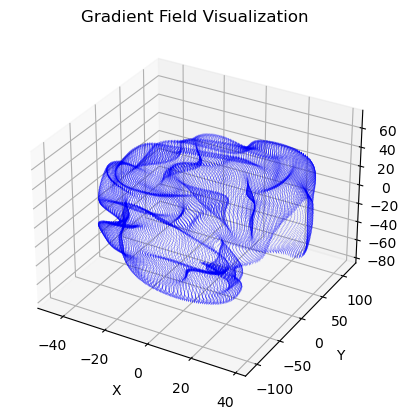

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have 'vertices' and 'gradient_field' with the correct shapes

# Create a 3D scatter plot of the vertices
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot arrows for the gradient field
for vertex, gradient_scalar in zip(vertices, gradient_field):
    gradient = gradient_scalar * np.array([1, 1, 1])  # Create a 3D vector from the scalar value
    ax.quiver(vertex[0], vertex[1], vertex[2], gradient[0], gradient[1], gradient[2], 
              length=0.1, normalize=True, color='b')  # You can customize the color as needed

# Customize the plot further if needed
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Gradient Field Visualization')

# Show the plot
plt.show()


In [82]:
print(f"- vertices: {vertices.shape} \n- triangles: {triangles.shape} \n- data: {data.shape} \n- normalized vertices: {vertex_normals.shape} \n- gradient_field: {gradient_field.shape}")

- vertices: (32492, 3) 
- triangles: (64980, 3) 
- data: (32492,) 
- normalized vertices: (32492, 3) 
- gradient_field: (32492,)


In [191]:
gradient_saxeL = gii_calc_gradient('saxe', gradient_savedir, hemi='L')
gradient_saxeR = gii_calc_gradient('saxe', gradient_savedir, hemi='R')

write_gifti(gradient_saxeL, hemi="L", output_dir=gradient_savedir, save_name="gradient_saxe")
write_gifti(gradient_saxeR, hemi="R", output_dir=gradient_savedir, save_name="gradient_saxe")

input surface data: /Users/h/Documents/projects_local/sandbox/gradient/saxeL.surf.gii
input surface data: /Users/h/Documents/projects_local/sandbox/gradient/saxeR.surf.gii


In [201]:
gradient_spuntL = gii_calc_gradient('spunt', gradient_savedir, hemi='L')
gradient_spuntR = gii_calc_gradient('spunt', gradient_savedir, hemi='R')

write_gifti(gradient_spuntL, hemi="L", output_dir=gradient_savedir, save_name="gradient_spunt")
write_gifti(gradient_spuntR, hemi="R", output_dir=gradient_savedir, save_name="gradient_spunt")

input surface data: /Users/h/Documents/projects_local/sandbox/gradient/spuntL.surf.gii
input surface data: /Users/h/Documents/projects_local/sandbox/gradient/spuntR.surf.gii


In [202]:
gradient_memL = gii_calc_gradient('retreivalGTencode', gradient_savedir, hemi='L')
gradient_memR = gii_calc_gradient('retreivalGTencode', gradient_savedir, hemi='R')
write_gifti(gradient_memL, hemi="L", output_dir=gradient_savedir, save_name="gradient_mem")
write_gifti(gradient_memR, hemi="R", output_dir=gradient_savedir, save_name="gradient_mem")

input surface data: /Users/h/Documents/projects_local/sandbox/gradient/retreivalGTencodeL.surf.gii
input surface data: /Users/h/Documents/projects_local/sandbox/gradient/retreivalGTencodeR.surf.gii


In [207]:
np.nanmax(gradient_memL)

171.12295532226562

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_29169/2890312465.py:261: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_29169/2890312465.py:261: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_29169/2890312465.py:261: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


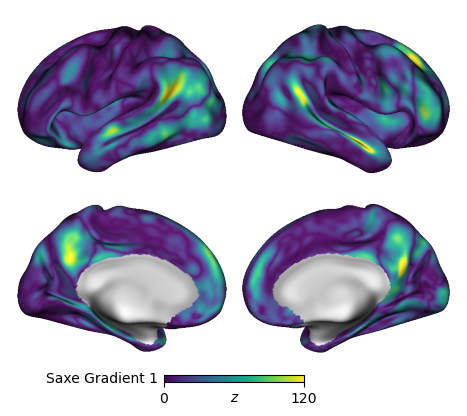

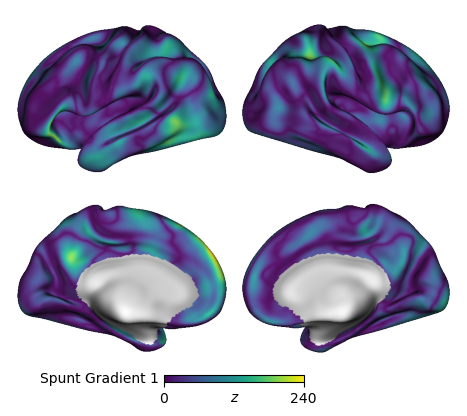

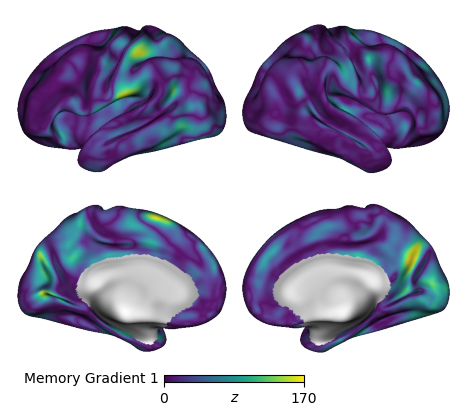

In [211]:
from surfplot import Plot
plot_task_surf(gradient_saxeL,gradient_saxeR, cmap_key=plt.cm.viridis, cmap_range=(0,120), cbar_label='Saxe Gradient 1')
plot_task_surf(gradient_spuntL,gradient_spuntR, cmap_key=plt.cm.viridis, cmap_range=(0,240), cbar_label='Spunt Gradient 1')
plot_task_surf(gradient_memL,gradient_memR, cmap_key=plt.cm.viridis, cmap_range=(0,170), cbar_label='Memory Gradient 1')

# Observations and thoughts
* The Left hemisphere gradient plots are almost the inverse version of the univariate maps, 
* whereas the Right hemisphere gradient map is a graded version of the univariate map.
* What's the best way to test whether these results are valid?